In [6]:
import pandas as pd
import numpy as np
import random as r
import matplotlib.pyplot as plt
from scipy import stats
from iminuit import Minuit                            
from numpy.linalg import inv
import sys
import inspect
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec


In [15]:
sys.path.append('External_Functions')
from ExternalFunctions import *

In [135]:
fake_data1 = np.random.normal(loc = 3, scale = 2, size  = 1000)
fake_data2 = np.random.normal(loc = 10, scale = 1, size  = 1000)
fake_data3 = np.random.normal(loc = 10, scale = 10, size  = 10)
fake_data4 = np.random.standard_t(df = 10,  size  = 100)

In [13]:
def get_weighted_mean(x, x_err):
    mean_weighted = np.nansum(x/x_err**2) / np.nansum(1/x_err**2)
    err_weighted = np.sqrt(1/np.sum(1 / x_err**2)) 
    chi2 = np.nansum((x - mean_weighted)**2/x_err**2)
    p = stats.chi2.sf(chi2, len(x) - 1)
    print(f'The weighted mean is:              {mean_weighted:.3f}')
    print(f'The error on the weighted mean is: {err_weighted:.3f}')
    print(fr'The $\chi^2$ is: {chi2:.3f}')
    print(f'The p value is : {p:.3f}')
    return mean_weighted, err_weighted, chi2, p

def get_separation(x, y, ddof = 0):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof = ddof)
    std_y = np.std(y, ddof = ddof)
    d = np.abs((mean_x - mean_y)) / np.sqrt(std_x**2 + std_y**2)
    return d


## functions

In [140]:
def gauss_pdf_norm(x, mu, sigma) :
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def lorentz_pdf_norm(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma) ** 2))


def prune(x, dist = 'z'):
    items_removed = []
    
    if dist == 'z':   
        sample_sigma = lambda array, mu, sig: abs(array - mu) / sig
        get_p        = lambda val, array : stats.norm.sf(val) * 2
    if dist == 't':
        sample_sigma = lambda array, mu, sig: abs(array - mu) / (sig )
        get_p        = lambda val, array : stats.t.sf(val, df = len(array) - 1) * 2

    while True:
        mu  = np.mean(x)
        sig = np.std(x, ddof = 1)
        statistics = sample_sigma(x, mu, sig)
        max_statistics = np.max(statistics)
        p  = get_p(max_statistics, x)
        if p < 1 / (len(x) * 2):
            index = np.argmax(statistics)
            items_removed.append(x[index])
            x = np.delete(x, index)
        else: 
            break
    return x, np.array(items_removed)


def calc_ROC(hist1, hist2) :
    # First we extract the entries (y values) and the edges of the histograms:
    y_sig, x_sig_edges, _ = hist1
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers):     
            # The cut mask
            cut = (x_centers < x)
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

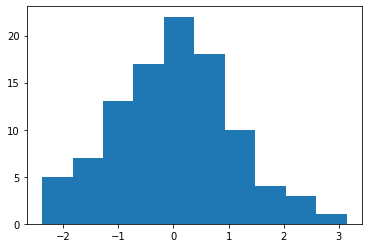

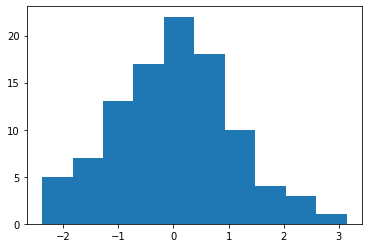

In [143]:
bob = fake_data4
plt.hist(bob,bins = 10)
plt.show()

bob, _ = prune(bob, dist= 't')
plt.hist(bob,bins = 10)
plt.show()


### Binned chi2 fit on unbinned data

In [ ]:
Nbins = 100
y_min = min(data)
y_max = max(data)

counts, bin_edges, _ = plt.hist(data, bins = Nbins, range = (y_min, y_max))
mask = counts > 0
x = ((bin_edges[1:] + bin_edges[:-1])/2)[mask]
counts = counts[mask]
norm = len(count) * (y_max - y_min) / Nbins
    
def chi2(*args):
    y_model = N * func(x, *args)
    return np.sum((counts - y_model)**2 / counts)
#    return np.sum((counts - y_model)**2 / y_model) # if there is a LOT of empty bins, use this instead and remove the mask

fit = Minuit(chi2_2, ...) 
fit.errordef = 1
fit.migrad()

chi2_val = fit.fval
p = stats.chi2.sf(chi2_val, len(counts) - ...)

values = fit.values[:]
errors = fit.errors[:]

# plotting

In [4]:
# ax and fig
fig, ax = plt.subplots(ncols=2,nrows = 2, figsize=(14, 6))

# adding text
dic = {r'$\chi^2$': 4,
       r'$n_{dof}$': 100,
       r'$p_{value}$': 0.1}
text = nice_string_output(dic, extra_spacing = 0, decimals = 2)
add_text_to_ax(0.2, 0.8, text, ax, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


x, y, y_err = ..., ..., ...
x_fit = np.linspace(min(x), max(x), 1000)
ax.plot(x_fit, func(x_fit, a, b), color = 'red', label = 'fit')
ax.fill_between(x_fit, func(x_fit, a+a_err, b+b_err), linear(x_fit, a-a_err, b-b_err), color = 'red',
                edgecolor = 'red', ls = 'dashed', alpha = 0.2, label = 'fit error')
ax.scatter(x, y, label = 'data')
ax.errorbar(x, y, yerr = y_err, fmt = 'o', capsize = 12, label = 'errorbars')



# for residual plots etc
fig = plt.figure(figsize = (16,8))
gs = gridspec.GridSpec(nrows = 2,ncols = 1, height_ratios=[3, 1], width_ratios = [1, 1], hspace = 0) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax1.xaxis.set_visible(False)




NameError: name 'plt' is not defined

# libararies

In [30]:
# for distributions

p_binomial = stats.binom.sf(4, n = 10, p = 0.2)
p_normal   = stats.norm.sf(4, loc = 20, scale = 3)
p_poisson   = stats.poisson.sf(4, mu = 10)
p_t   = stats.t.sf(4,  df = 3, loc = 6, scale = 2)

# remeber if you want both tails to multiply by two 


p_shapiro = stats.shapiro(fake_data1)[1] # normaility test
p_ks      = stats.kstest(fake_data1, fake_data2)

correlation_pear = stats.pearsonr(fake_data1, fake_data2)
correlation_spearman = stats.spearmanr(fake_data1, fake_data2)
